# test handling all collocation event lists

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '..')

from atl09_cloudnet.definitions.collocation import DistanceFromLocation, Duration, RadiusDuration, RawATL09, RawCloudnet
from atl09_cloudnet.definitions import vcf
from sat_val_framework import CollocationEventList

In [2]:
import os
import datetime as dt
import numpy as np
import random

In [3]:
dir_pickles = "/work/scratch-nopw2/eeasm/get_collocation_events_pickles"
assert os.path.isdir(dir_pickles)

In [4]:
sites = {
    "ny-alesund": dict(lat=78.923, lon=11.922), 
    "hyytiala": dict(lat=61.844, lon=24.287), 
    "juelich": dict(lat=50.908, lon=6.413), 
    "munich": dict(lat=48.148, lon=11.573),
}

In [5]:
SITE = "ny-alesund"
#SITE = "munich"
LATITUDE = sites[SITE]["lat"]
LONGITUDE = sites[SITE]["lon"]
SITE, LATITUDE, LONGITUDE

('ny-alesund', 78.923, 11.922)

In [6]:
fname_full_list = f"collocation_events_{SITE}.pkl"
fname_full_list

'collocation_events_ny-alesund.pkl'

In [7]:
R_km = 150
duration = dt.timedelta(hours=36)
JOINT_PARAMS = RadiusDuration({
    RawATL09: DistanceFromLocation(
        distance_km=R_km, 
        latitude = LATITUDE,
        longitude = LONGITUDE,
    ),
    RawCloudnet: Duration(duration=duration)
})
JOINT_PARAMS

{<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: DistanceFromLocation(distance_km=150, latitude=78.923, longitude=11.922, MINIMUM_REQUIRED_PROFILES=50), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: Duration(duration=datetime.timedelta(days=1, seconds=43200))}

In [8]:
all_collocation_events = CollocationEventList.from_file(
    os.path.join(dir_pickles, fname_full_list)
)
len(all_collocation_events)

1105

# Random event plotting

In [9]:
import matplotlib.pyplot as plt
import cmcrameri as cm
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from textwrap import wrap

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [10]:
def spatial_extent_plot(ax, raw_atl09):
    ax.coastlines("10m")
    ax.add_feature(cfeature.LAND)
    for p, pdisp in zip(raw_atl09.data.profile, (1,2,3,)):
        d = raw_atl09.data.sel(profile=p)
        ax.plot(d["longitude"], d["latitude"], transform=ccrs.PlateCarree(), label=f"{pdisp}", lw=1, c="green")
    
    ax.scatter(
        JOINT_PARAMS[RawATL09].longitude, JOINT_PARAMS[RawATL09].latitude, transform=ccrs.PlateCarree(), marker = "*", fc="red", s=500, ec="k", lw=1.5, zorder=10
    )
    
    
    limit_km = 210
    limits = [ limit_km * 1000 * p for p in (-1, 1)]
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    
    tick_km = [-200, -150, -100, -50, 0, 50, 100, 150, 200]
    #tick_km = [-150, -100, -50, 0, 50, 100, 150]
    tick_m = [1000*v for v in tick_km]
    ax.set_xticks(tick_m)
    ax.set_xticklabels(tick_km)
    ax.set_xlabel("Easting (km)")
    ax.set_yticks(tick_m)
    ax.set_yticklabels(tick_km)
    ax.set_ylabel("Northing (km)")
    
    ax.add_patch(
        Circle(
            xy = (0,0),
            radius = JOINT_PARAMS[RawATL09].distance_km*1000,
            lw=2, ls="--", ec="k", 
            fc="none", #alpha=0
        )
    )
    
    #ax.add_patch(
    #    Circle(
    #        xy = (0,0),
    #        radius = 150*1000,
    #        lw=1, ls="--", ec="k", 
    #        fc="none", #alpha=0
    #    )
    #)

In [11]:
def atl09_feature_mask_criteria_plots(ax_featuremask, ax_criteria, raw_atl09):
    p=0
    pdata = (
        raw_atl09.data
            .isel(profile=p)
            #.sel(height=slice(0,10_000))
            .feature_mask
            .fillna(0)
    )
    pdata.plot(
        x="time", y="height",
        ax=ax_featuremask,
        add_colorbar=False
    )
    ax_featuremask.set_ylim([0, 12_000])
    ax_featuremask.set_xlim([pdata.time.min(), pdata.time.max()])
    
    d2s = JOINT_PARAMS[RawATL09].get_distance_to_location(raw_atl09)
    d2s.unstack().isel(profile=p).rename(f"Distance to {SITE} (km)").plot(
        x="time",
        ax=ax_criteria
    )
    ax_criteria.set_ylim([0,None])

In [12]:
def cloudnet_feature_mask_criteria_plots(ax_featuremask, ax_criteria, raw_cloudnet, t0):
    (
        raw_cloudnet.data.cloudmask
            .sel(height=slice(0,12_000))
    ).plot(
        x="time", y="height",
        ax=ax_featuremask,
        add_colorbar=False
    )

    abs_t_t0 = np.abs(
        (raw_cloudnet.data.time - np.datetime64(t0)) * 1e-9
    ).rename(r"$|t - t_{0}|$ (s)")
    abs_t_t0.plot(
        x="time",
        ax=ax_criteria
    )
    ax_criteria.set_ylim([0, None])

In [16]:
random_event = random.choice(all_collocation_events)
coll_raw_data = random_event.load_with_joint_parameters(JOINT_PARAMS)
random_event

/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:150: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:151: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


{<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20210714135623_03201201_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2021, 7, 14, 14, 17, 1, 887331), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:339: UserWarning: Discarding nonzero nanoseconds in conversion.
  return Timestamp(t0_dt64).to_pydatetime()


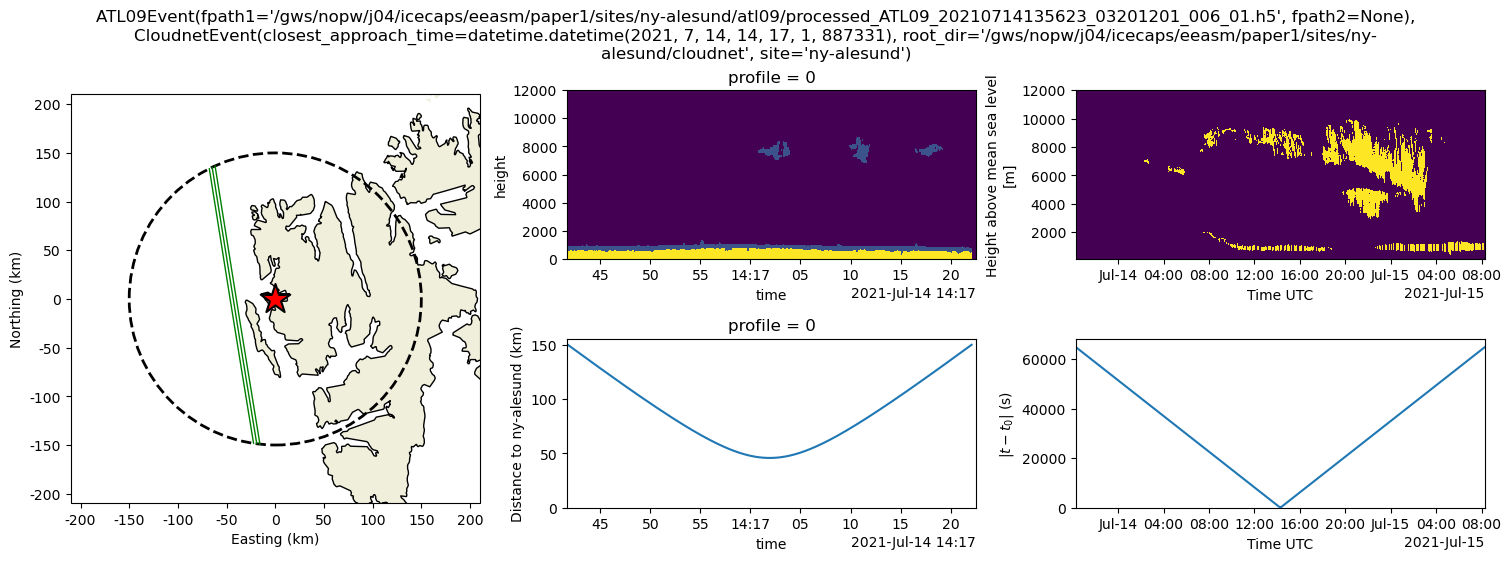

In [17]:
assert not any((value is None for value in coll_raw_data.values()))

fig = plt.figure(figsize=(15, 5.5), layout="constrained")
fig.suptitle( "\n".join(wrap(f"{random_event[RawATL09]}, {random_event[RawCloudnet]}", 150)) )

PROJ = ccrs.Orthographic(
    central_latitude=JOINT_PARAMS[RawATL09].latitude,
    central_longitude=JOINT_PARAMS[RawATL09].longitude
)


ax_spatial = fig.add_subplot(2,3,(1,4), projection=PROJ)
ax_atl09_cloudmask = fig.add_subplot(2,3,2)
ax_atl09_criteria = fig.add_subplot(2,3,5, sharex=ax_atl09_cloudmask)
ax_cloudnet_cloudmask = fig.add_subplot(2,3,3)
ax_cloudnet_criteria = fig.add_subplot(2,3,6, sharex=ax_cloudnet_cloudmask)

spatial_extent_plot(ax_spatial, coll_raw_data[RawATL09])
atl09_feature_mask_criteria_plots(ax_atl09_cloudmask, ax_atl09_criteria, coll_raw_data[RawATL09])

t0 = JOINT_PARAMS[RawATL09].get_time_closest_approach(coll_raw_data[RawATL09])
cloudnet_feature_mask_criteria_plots(ax_cloudnet_cloudmask, ax_cloudnet_criteria, coll_raw_data[RawCloudnet], t0)

plt.show()